In [1]:
import n2d2
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets
from neurocorgi_sdk.models import NeuroCorgiNet_torch

In [2]:
# If possible, set up the GPU 7 for the application
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

n2d2.global_variables.default_model = "Frame_CUDA" if n2d2.global_variables.cuda_available else "Frame"
n2d2.global_variables.cuda_device = 7

n2d2.global_variables.verbosity = 0

In [3]:

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       ])

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      ])

dataset_train = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=train_transforms)
dataset_test = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=False, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image.clip(0, 1)
  return image

In [5]:
classes = train_loader.dataset.classes
print(classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

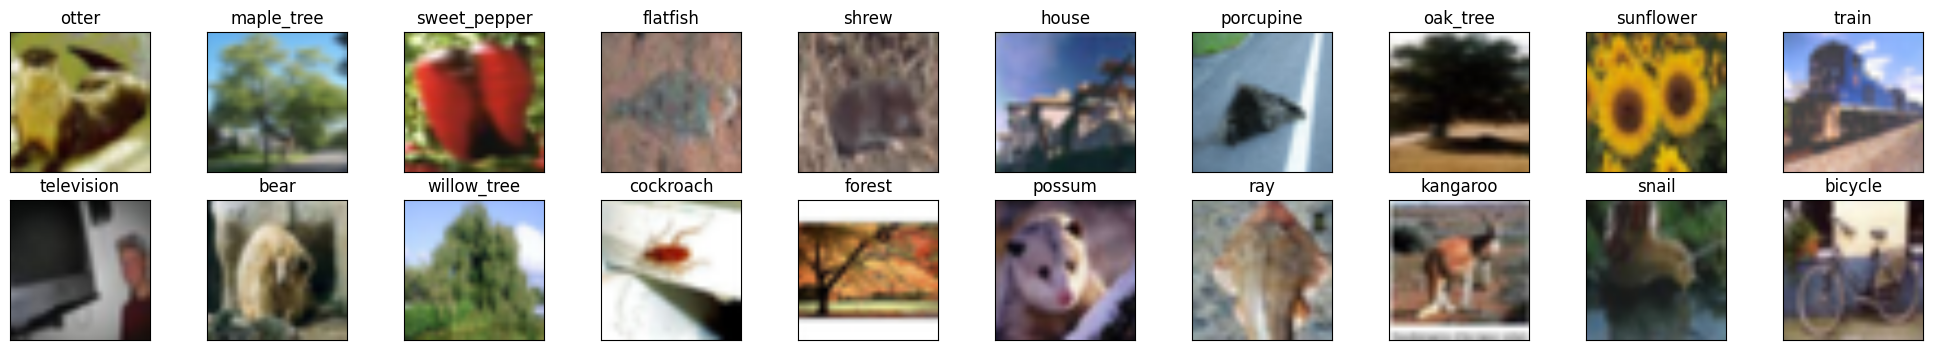

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [7]:
# For this example, we use the model pretrained and quantized with the ImageNet dataset
extractor = NeuroCorgiNet_torch([128, 3, 224, 224], weights_dir="data/imagenet_weights")
extractor.to(device)

Adding cell (extractor) : bn1
Adding cell (extractor) : bn1_3x3_dw
Adding cell (extractor) : bn1_1x1
Adding cell (extractor) : bn2_3x3_dw
Adding cell (extractor) : bn2_1x1
Adding cell (extractor) : bn3_3x3_dw
Adding cell (extractor) : bn3_1x1
Adding cell (extractor) : bn4_3x3_dw
Adding cell (extractor) : bn4_1x1
Adding cell (extractor) : bn5_3x3_dw
Adding cell (extractor) : bn5_1x1
Adding cell (extractor) : bn6_3x3_dw
Adding cell (extractor) : bn6_1x1
Adding cell (extractor) : bn7_1_3x3_dw
Adding cell (extractor) : bn7_1_1x1
Adding cell (extractor) : bn7_2_3x3_dw
Adding cell (extractor) : bn7_2_1x1
Adding cell (extractor) : bn7_3_3x3_dw
Adding cell (extractor) : bn7_3_1x1
Adding cell (extractor) : bn7_4_3x3_dw
Adding cell (extractor) : bn7_4_1x1
Adding cell (extractor) : bn7_5_3x3_dw
Adding cell (extractor) : bn7_5_1x1
Adding cell (extractor) : bn8_3x3_dw
Adding cell (extractor) : bn8_1x1
Adding cell (extractor) : bn9_3x3_dw
Adding cell (extractor) : bn9_1x1
Import data/imagenet_weight

NeuroCorgiNet_torch(
  (pytorch_neurocorgi): Block()
)

In [8]:
pool = torch.nn.AvgPool2d(7, stride=7)
flatten = torch.nn.Flatten(start_dim=1)
classifier = torch.nn.Linear(1024, 100)
head = torch.nn.Sequential(pool, flatten, classifier)
head.to(device)

Sequential(
  (0): AvgPool2d(kernel_size=7, stride=7, padding=0)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1024, out_features=100, bias=True)
)

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(head.parameters(), lr=0.01)

In [10]:
extractor = extractor.eval()
head = head.train()

In [11]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for i, (inputs, labels) in enumerate(tqdm(train_loader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    conv3_1x1, conv5_1x1, conv7_5_1x1, conv9_1x1 = extractor(inputs)
    outputs = head(conv9_1x1)

    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
      with torch.no_grad():
        for i, (val_inputs, val_labels) in enumerate(tqdm(test_loader)):
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)

          conv3_1x1, conv5_1x1, conv7_5_1x1, conv9_1x1 = extractor(val_inputs)
          val_outputs = head(conv9_1x1)

          val_loss = criterion(val_outputs, val_labels)
          
          _, val_preds = torch.max(val_outputs, 1)
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == val_labels.data)
        
      epoch_loss = running_loss/len(train_loader.dataset)
      epoch_acc = running_corrects.float()/ len(train_loader.dataset)
      running_loss_history.append(epoch_loss)
      running_corrects_history.append(epoch_acc)
      
      val_epoch_loss = val_running_loss/len(test_loader.dataset)
      val_epoch_acc = val_running_corrects.float()/ len(test_loader.dataset)
      val_running_loss_history.append(val_epoch_loss)
      val_running_corrects_history.append(val_epoch_acc)
      print('epoch :', (e+1))
      print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
      print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

100%|██████████| 78/78 [00:26<00:00,  2.90it/s]


epoch : 1
training loss: 0.0220, acc 0.3755 
validation loss: 0.0157, validation acc 0.5158 


100%|██████████| 78/78 [00:26<00:00,  2.93it/s]


epoch : 2
training loss: 0.0138, acc 0.5631 
validation loss: 0.0129, validation acc 0.5774 


100%|██████████| 78/78 [00:27<00:00,  2.87it/s]


epoch : 3
training loss: 0.0119, acc 0.6019 
validation loss: 0.0117, validation acc 0.6040 


100%|██████████| 78/78 [00:26<00:00,  2.94it/s]


epoch : 4
training loss: 0.0110, acc 0.6263 
validation loss: 0.0111, validation acc 0.6131 


100%|██████████| 78/78 [00:28<00:00,  2.70it/s]


epoch : 5
training loss: 0.0104, acc 0.6404 
validation loss: 0.0107, validation acc 0.6254 


100%|██████████| 78/78 [00:26<00:00,  2.95it/s]


epoch : 6
training loss: 0.0099, acc 0.6507 
validation loss: 0.0104, validation acc 0.6330 


100%|██████████| 78/78 [00:26<00:00,  2.92it/s]


epoch : 7
training loss: 0.0096, acc 0.6610 
validation loss: 0.0102, validation acc 0.6350 


100%|██████████| 78/78 [00:26<00:00,  2.97it/s]


epoch : 8
training loss: 0.0093, acc 0.6692 
validation loss: 0.0100, validation acc 0.6407 


100%|██████████| 78/78 [00:26<00:00,  2.96it/s]


epoch : 9
training loss: 0.0091, acc 0.6767 
validation loss: 0.0099, validation acc 0.6445 


100%|██████████| 78/78 [00:26<00:00,  2.95it/s]


epoch : 10
training loss: 0.0089, acc 0.6835 
validation loss: 0.0097, validation acc 0.6505 


100%|██████████| 78/78 [00:29<00:00,  2.61it/s]


epoch : 11
training loss: 0.0087, acc 0.6877 
validation loss: 0.0096, validation acc 0.6521 


100%|██████████| 78/78 [00:26<00:00,  2.91it/s]


epoch : 12
training loss: 0.0085, acc 0.6940 
validation loss: 0.0095, validation acc 0.6559 


100%|██████████| 78/78 [00:27<00:00,  2.83it/s]


epoch : 13
training loss: 0.0084, acc 0.6980 
validation loss: 0.0094, validation acc 0.6593 


100%|██████████| 78/78 [00:27<00:00,  2.86it/s]


epoch : 14
training loss: 0.0082, acc 0.7011 
validation loss: 0.0094, validation acc 0.6618 


100%|██████████| 78/78 [00:28<00:00,  2.79it/s]

epoch : 15
training loss: 0.0081, acc 0.7055 
validation loss: 0.0093, validation acc 0.6638 


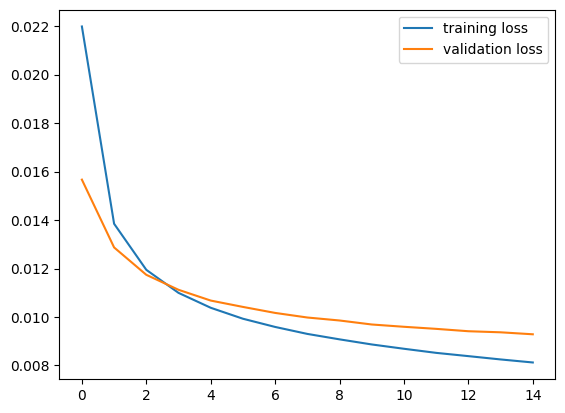

In [12]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

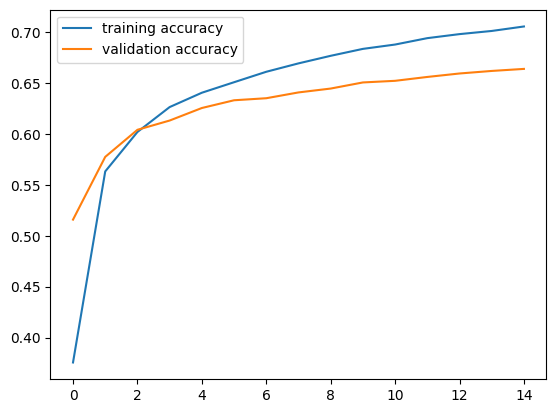

In [13]:
running_corrects_history = [x.to("cpu") for x in running_corrects_history]
val_running_corrects_history = [x.to("cpu") for x in val_running_corrects_history]

plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

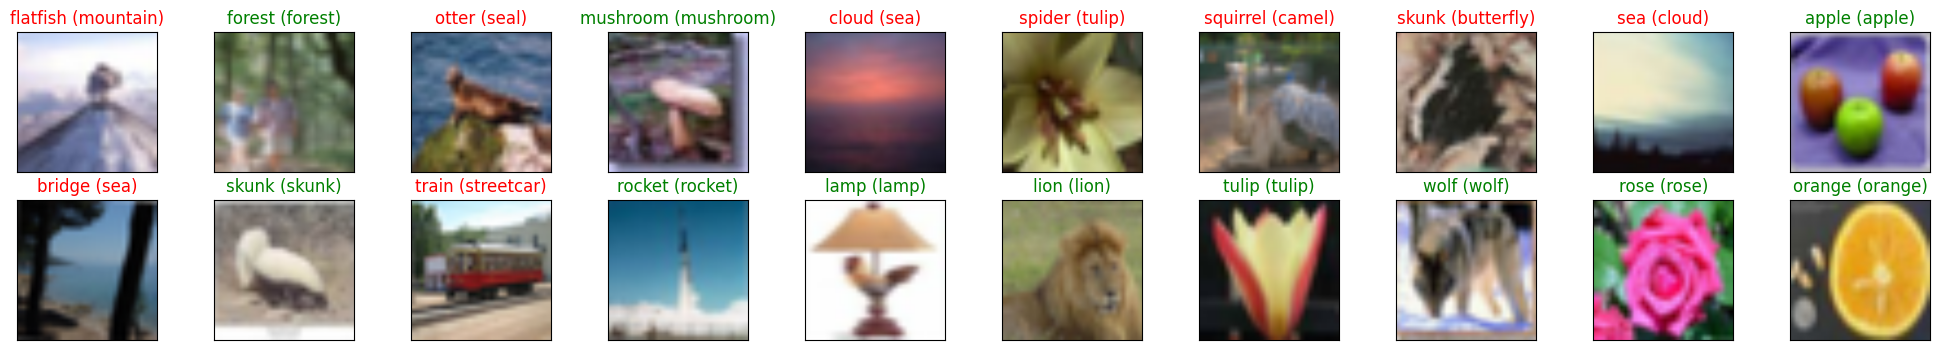

In [16]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

conv3_1x1, conv5_1x1, conv7_5_1x1, conv9_1x1 = extractor(images)
output = head(conv9_1x1)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))